# Audiofeatures for AI-TD
We need a more or less big feature vector directly derived from a recorded waveform. To be specific, we want the audiofeatures of a **1 s** frame from a recording which may have any length between **1** and **5** seconds. After that, we can take the mean of all these frames. Some features may be linked to a peak in the signal or output an array which can be averaged. As it stands, we only want scalar values for each feature per frame, which after averaging also means one value per recording, making the inputs for the neural net easy to handle. The features are listed here and described and commputed below:

- $T_{1A}$ : Analytical time constant of rise time of the most significant event in frame.
- $T_{2A}$ : Analytical time constant of fall time of the most significant event in frame.
- $G_{1H}$ : Attack-gain setting.
- $G_{2H}$ : Sustain-gain setting.
- $F$ : Tonality.
- $D_v$ : Dynamic variation.
- $C_S$ : Spectral centroid.
- $V$ : Vocality.
- $BPM$ : Beats per minute (beat detection).
- $P_{band}$ : Power in certain band.

*Abbreviations:*  
*$H$* : human-generated  
*$A$* : analytically generated  

The audiofeatures computed below are purposefully **NOT** pythonic, because they have to be ported into C/C++ for an embedded system and writing them C-like makes that process easier, as we do not rely on magic library functions.

In [50]:
"""
General imports and loading of the audio file for development and explorative research.
The audio signal is normalized in the time domain to its highest value.
"""

import numpy as np
import matplotlib.pyplot as plt
%run transient_shaper_lib.ipynb

FRAME_LEN = 1   # in s
fs, x = sp.io.wavfile.read("shaker.wav")
try:
    x = x[:, 0]
except:
    pass
num_samples = len(x)
n_bits = 32
x = x / (2**n_bits / 2)

# normalize
x /= np.max(x)

t = np.linspace(0, num_samples- 1, num_samples) / fs


# $T_{1A}$ & $T_{2A}$
$T_{1A}$ and $T_{2A}$ are the time constants describing the duration of attack ($T_1$) and release ($T_2$). In this case, we define $T_1$ to be the time it takes to rise from the first detected minimum in the smoothed envelope $x_e$ to the peak value in a frame. $x_e$ is derived from applying cascaded exponential envelope filters onto the audio signal. The parameters which produce these filters are listed below in code. $T_2$ is obtained by calculating the time between the frame's peak and the next detected minimum. After each $T_1$ and $T_2$ have been found per frame, a mean calculation breaks them down into one scalar value per audio file.

In [51]:
"""
Constants for the envelope followers
"""
ENV_SMOOTH_ORDER = 4            # in n
ENV_SMOOTH_ATTACK = 2           # in ms
ENV_SMOOTH_RELEASE = 200        # in ms
EXTREMA_SEARCH_INTERVAL = 4000  # in samples

"""
Apply the envelope followers onto a given signal.
"""
def getEnvelope(sig: np.ndarray) -> np.ndarray:
    order = 4
    attack = 2
    release = 200
    smooth_fast = ExpSmooth(ENV_SMOOTH_ORDER)
    smooth_fast.reset(fs)
    smooth_fast.set_attack(ENV_SMOOTH_ATTACK)
    smooth_fast.set_release(ENV_SMOOTH_RELEASE)
    env_smooth = np.zeros(num_samples)
    for i, sample in enumerate(sig):
        env_smooth[i] = smooth_fast.process(sample)
    return env_smooth

env_smooth = getEnvelope(x)

"""
Get the index of the peak value of a given signal within a range of samples.
"""
def getIdxOfMax(sig: np.ndarray, from_idx: int, to_idx: int) -> int:
    idx_max = from_idx
    for i in range(from_idx, to_idx):
        if(sig[i] > sig[idx_max]):
            idx_max = i
    return idx_max


"""
Get the index of the smallest value of a given signal within a range of samples.
"""
def getIdxOfMin(sig: np.ndarray, from_idx: int, to_idx: int) -> int:
    idx_min = from_idx
    for i in range(from_idx, to_idx):
        if(sig[i] < sig[idx_min]):
            idx_min = i
    return idx_min

"""
Calculate T_1 and T_2 per frame and return them as both mean values and one value per frame.
"""
def getTA(sig: np.ndarray) -> int:
    T1As = []
    T2As = []
    frames = num_samples // (FRAME_LEN * fs) # ignore residual samples which don't form a full frame
    for i in range(0, frames):
        l_bound = i*fs
        u_bound = (i+1)*fs-1
        idx_max = getIdxOfMax(sig, l_bound, u_bound)
        if idx_max < search_interval:
            start = l_bound
        else:
            start = idx_max - search_interval
        idx_min_pre = getIdxOfMin(sig, start, idx_max)

        if idx_max + search_interval > u_bound:
            stop = u_bound
        else:
            stop = idx_max + search_interval
        idx_min_post = getIdxOfMin(env_smooth, idx_max, stop)
        T1As.append((idx_max - idx_min_pre) / fs)
        T2As.append((idx_min_post - idx_max) / fs)
    T1A = np.sum(np.asarray(T1As))
    T2A = np.sum(np.asarray(T2As))
    return T1A / frames, T1As, T2A / frames, T2As

T1A, T1As, T2A, T2As = getTA(env_smooth)
print(f"Analytical attack time (mean): {T1A:.5f} s")
print(f"Analytical release time (mean): {T2A:.5f} s")


Analytical attack time (mean): 0.02783 s
Analytical release time (mean): 0.09068 s


# $G_{1H}$ & $G_{2H}$
$G_{1H}$ and $G_{2H}$ represent the given gain value for the attack or release control voltage in the AI-TD. This is a human parameter and can't be derived from the signal, as it is purely determined by taste, hence the $H$ for "human". In the embedded program, this value is derived from the position of potentiometers that the user dialed in.

# $F$
Tonality. Describes how "tonal" audio is. Right now, we treat this feature as the NOT percentage of spectral flatness, meaning a tonality of 0.3 for a signal with a spectral flatness of 0.7.

Other ideas include:
- [link](https://community.sw.siemens.com/s/article/Tonality) for definitions
- [link](https://github.com/cocosci/pam-nac) for a python implementation (looks messy)


In [52]:
def getTonality(sig):
    spectrum = np.fft.fft(sig)
    power_spectrum = np.abs(spectrum)**2
    arithmetic_mean = 0
    sum_of_logs = 0

    for i in range(len(power_spectrum)):
        arithmetic_mean += power_spectrum[i]
        if power_spectrum[i] > 0:  # Avoid log(0)
            sum_of_logs += np.log(power_spectrum[i])

    arithmetic_mean /= len(power_spectrum)
    geometric_mean = np.exp(sum_of_logs / len(power_spectrum))

    if arithmetic_mean == 0:
        return np.inf

    flatness = geometric_mean / arithmetic_mean
    return 1 - flatness


print(f"Tonality: {getTonality(x):.2f}")

Tonality: 0.89


# $D_v$
Calculate the dynamic variation of a signal. Idea: Combine the amount of peaks and valleys and their deltas.


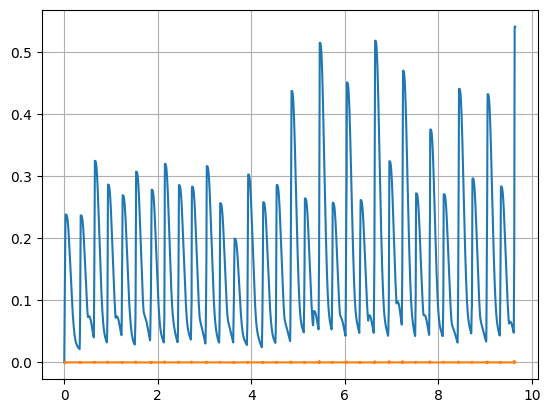

In [53]:
def calculate_derivative(sig):
    deriv = [0] * len(sig)
    for i in range(1, len(sig)):
        deriv[i] = sig[i] - sig[i-1]
    return deriv

plt.plot(t, env_smooth)
plt.plot(t, calculate_derivative(env_smooth))
plt.grid()
